In [2]:
import random
import gzip
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

In [3]:
df = pd.read_pickle('./Dataset_BPR/Steam_train_val.pkl')
df_train = pd.read_pickle('./Dataset_BPR/Steam_trainSet.pkl')
df_val = pd.read_pickle('./Dataset_BPR/Steam_valSet.pkl')
df_test = pd.read_pickle('./Dataset_BPR/Steam_testSet.pkl')

allGames = []
for i in df.gameID:
    allGames += i
game_set = set(allGames)
game_list = list(game_set)
user_list = list(df.userID)

num_items = len(game_set)
num_users = len(user_list)

df_train_indexby_userID = df_train.set_index('userID')

user_index_map = dict([(user_list[i], i) for i in range(len(user_list))])
game_index_map = dict([(game_list[i], i) for i in range(len(game_list))])

In [4]:
# parameters
epochs = 500
lr = 0.001
lam = 0.01
dims = 10

beta = np.zeros((num_items))
t = np.zeros((num_users, dims))
gamma = np.random.rand(num_items, dims)
T =np.random.rand(1, dims)

# Normalize gamma and t
gamma = gamma / np.linalg.norm(gamma, axis=1).reshape(-1, 1)
T = T / np.linalg.norm(T)

In [5]:
def get_neg_item(u, j):
    return random.choice(list(game_set - {j}))
    #return random.choice(list(game_set - set(df_train_indexby_userID.iat[u, 0])))
#     j_neg = sequence_dict[u][0]
#     while j_neg in sequence_dict[u]:
#         j_neg = I[np.random.randint(0, num_items)]
    
#     return j_neg

def Euclidean_d(a, b):
    return np.linalg.norm(a - b)

def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

# def normalize(gamma):
#     gamma_norm = np.linalg.norm(gamma, axis=1).reshape(-1, 1)
#     mask = gamma_norm <= 1
#     gamma_morm[mask] = 1
#     gamma = gamma / gamma_norm
#     return gamma

def normalize(i1, i2, i3):
    for i in [i1, i2, i3]:
        g = np.linalg.norm(gamma[i])
        if g > 1:
            gamma[i] = gamma[i]
        else:
            pass

#batch_size = 32

#gamesTrain = list(df_train.gameID)


def compute_metrics(trainData, testData, thres=10):
    #threshold = defaultdict(list)
    Hit = defaultdict(int)
    NDCG = defaultdict(float)
    AUC = defaultdict(float)
    gameTrain = list(trainData.gameID)
    gameTest = list(testData.gameID)
    for u_idx in trainData.index:
        #u_idx = user_index_map[u]
        game_val = []
        i = gameTrain[u_idx][-1]
        i_idx = game_index_map[i]
        j = gameTest[u_idx][0]
        j_idx = game_index_map[j]
        p_u_i_j = beta[j_idx] - Euclidean_d(gamma[i_idx] + T + t[u_idx], gamma[j_idx])
        game_val.append(p_u_i_j)
        for j_neg in gameTest[u_idx][1:]:
            j_neg_idx = game_index_map[j_neg]
            p_u_i_j_neg = beta[j_neg_idx] - Euclidean_d(gamma[i_idx] + T + t[u_idx], gamma[j_neg_idx])
            game_val.append(p_u_i_j_neg)
        #GT = game_val[0]
        game_val.sort(reverse=True)
        
        rank = game_val.index(p_u_i_j)
        AUC[u_idx] = (100 - rank) / 100
        if rank <= 9:
            Hit[u_idx] = 1
            NDCG[u_idx] = 1 / np.log2(rank + 2)
        else:
            Hit[u_idx] = 0
            NDCG[u_idx] = 0.0
        
    return sum(Hit.values()) / len(Hit), sum(NDCG.values()) / len(NDCG), sum(AUC.values()) / len(AUC)


def transRec(epochs, lr, lam, dims):
    # Parameter set
    HIT = []
    NDCG = []
    AUC_list = []
    OBJ = []
    #optimizer = torch.optim.SGD([gamma, t, T, beta], lr=lr, weight_decay = lam)
    gamesTrain = list(df_train.gameID)
    for e in range(epochs):

        objective = 0
        #loss_accu = 0

        #for _ in range(batch_size):
        for u_idx in range(num_users):
            #u_idx = np.random.randint(0, num_users)
            #u = U[u_idx]
            u_gameSequence = gamesTrain[u_idx]

            for rand_i in range(len(u_gameSequence) - 1):
                #optimizer.zero_grad()
                #rand_i = np.random.randint(0, len(u_gameSequence) - 1)
                i = u_gameSequence[rand_i]
                #i = random.choice(u_gameSequence)
                j = u_gameSequence[rand_i + 1]
                j_neg = get_neg_item(u_idx, j)

                i_idx = game_index_map[i]
                j_idx = game_index_map[j]
                j_neg_idx = game_index_map[j_neg]

                a = gamma[i_idx] + T[0] + t[u_idx]
                b1 = gamma[j_idx]
                #a2 = gamma[i_idx] + T + t[u_idx]
                b2 = gamma[j_neg_idx]
                p_u_i_j = beta[j_idx] - Euclidean_d(a, b1)
                p_u_i_j_neg = beta[j_neg_idx] - Euclidean_d(a, b2)

#                 reg = lam * (np.linalg.norm(T) + np.linalg.norm(gamma[i_idx]) + np.linalg.norm(t[u_idx]) + \
#                              np.linalg.norm(gamma[j_idx]) + np.linalg.norm(gamma[j_neg_idx]) + \
#                              np.linalg.norm(beta[j_idx]) + np.linalg.norm(beta[j_neg_idx]))
                
                z = sigmoid(p_u_i_j - p_u_i_j_neg)
                
                d2 = a - b2
                d1 = a - b1
                
                beta[j_idx] += lr * (-(1-z) - lam * beta[j_idx])
                beta[j_neg_idx] += lr * ((1-z) - lam * beta[j_neg_idx])
                gamma[i_idx] += lr * ((1-z) * 2 * (d2-d1) - lam * gamma[i_idx])
                gamma[j_idx] += lr * ((1-z) * 2 * d1 - lam * gamma[j_idx])
                gamma[j_neg_idx] += lr * ((1-z) * 2 * (-d2) - lam * gamma[j_neg_idx])
                T[0] += lr * ((1-z) * 2 *(d2-d1) - lam * T[0])
                t[u_idx] += lr * ((1-z) * 2 * (d2-d1) - lam * t[u_idx])
                
                normalize(i_idx, j_idx, j_neg_idx)

                loss = -np.log(z)
                #loss_accu += loss
                objective += loss #+ reg

                
                #gamma = normalize(gamma)
            
        hit_at10, NDCG_at10, AUC = compute_metrics(df_train, df_val)
        print('Iteration %s \t Objective %.2f \t Hit@10 %.4f \t NDCG@10 %.4f \t AUC %.4f' \
              %(e+1, objective, hit_at10, NDCG_at10, AUC))
        
        HIT.append(hit_at10)
        NDCG.append(NDCG_at10)
        AUC_list.append(AUC)
        OBJ.append(objective)
        
    return OBJ, HIT, NDCG, AUC_list

In [6]:
OBJ10, HIT10, NDCG10, AUC_list10 = transRec(epochs, lr, lam, dims)

Iteration 1 	 Objective 18341.84 	 Hit@10 0.1095 	 NDCG@10 0.0507 	 AUC 0.5253
Iteration 2 	 Objective 18170.39 	 Hit@10 0.1400 	 NDCG@10 0.0644 	 AUC 0.5544
Iteration 3 	 Objective 17928.81 	 Hit@10 0.2150 	 NDCG@10 0.1198 	 AUC 0.6055
Iteration 4 	 Objective 17538.10 	 Hit@10 0.3213 	 NDCG@10 0.2029 	 AUC 0.6637
Iteration 5 	 Objective 16889.13 	 Hit@10 0.4271 	 NDCG@10 0.2623 	 AUC 0.7117
Iteration 6 	 Objective 16008.97 	 Hit@10 0.4876 	 NDCG@10 0.2903 	 AUC 0.7450
Iteration 7 	 Objective 15061.21 	 Hit@10 0.5114 	 NDCG@10 0.2987 	 AUC 0.7639
Iteration 8 	 Objective 14098.34 	 Hit@10 0.5185 	 NDCG@10 0.3017 	 AUC 0.7751
Iteration 9 	 Objective 13276.16 	 Hit@10 0.5213 	 NDCG@10 0.3017 	 AUC 0.7796
Iteration 10 	 Objective 12620.54 	 Hit@10 0.5227 	 NDCG@10 0.3043 	 AUC 0.7817
Iteration 11 	 Objective 12070.00 	 Hit@10 0.5217 	 NDCG@10 0.3031 	 AUC 0.7827
Iteration 12 	 Objective 11700.14 	 Hit@10 0.5220 	 NDCG@10 0.3040 	 AUC 0.7828
Iteration 13 	 Objective 11468.12 	 Hit@10 0.5213

In [5]:
OBJ, HIT, NDCG, AUC_list = transRec(epochs, lr, lam, dims)

Iteration 1 	 Objective 18231.78 	 Hit@10 0.1635 	 NDCG@10 0.0830 	 AUC 0.5779
Iteration 2 	 Objective 18021.01 	 Hit@10 0.2345 	 NDCG@10 0.1340 	 AUC 0.6358
Iteration 3 	 Objective 17703.78 	 Hit@10 0.3451 	 NDCG@10 0.2139 	 AUC 0.6952
Iteration 4 	 Objective 17171.58 	 Hit@10 0.4456 	 NDCG@10 0.2717 	 AUC 0.7398
Iteration 5 	 Objective 16431.10 	 Hit@10 0.4968 	 NDCG@10 0.2928 	 AUC 0.7657
Iteration 6 	 Objective 15486.33 	 Hit@10 0.5174 	 NDCG@10 0.3011 	 AUC 0.7773
Iteration 7 	 Objective 14556.39 	 Hit@10 0.5245 	 NDCG@10 0.3034 	 AUC 0.7833
Iteration 8 	 Objective 13645.45 	 Hit@10 0.5249 	 NDCG@10 0.3051 	 AUC 0.7843
Iteration 9 	 Objective 12892.55 	 Hit@10 0.5284 	 NDCG@10 0.3056 	 AUC 0.7849
Iteration 10 	 Objective 12264.27 	 Hit@10 0.5249 	 NDCG@10 0.3050 	 AUC 0.7851
Iteration 11 	 Objective 11899.96 	 Hit@10 0.5242 	 NDCG@10 0.3039 	 AUC 0.7841
Iteration 12 	 Objective 11445.82 	 Hit@10 0.5242 	 NDCG@10 0.3036 	 AUC 0.7840
Iteration 13 	 Objective 11284.54 	 Hit@10 0.5238

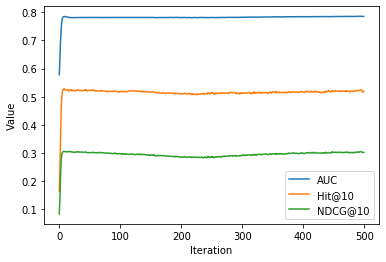

In [7]:
plt.plot(AUC_list, label='AUC')
plt.plot(HIT, label='Hit@10')
plt.plot(NDCG, label='NDCG@10')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
# plt.ylabel('AUC')
plt.savefig('transRec.png', transparent=True)

In [10]:
max(AUC_list)

0.7859914712153532